<a href="https://colab.research.google.com/github/CScheuerman/lab-5-CScheuerman/blob/main/DATA_301_Lab_5_Phase_2_Carly_Scheuerman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [83]:
import pandas as pd
import numpy as np
import requests
from collections import Counter
from operator import itemgetter


## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words across the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

In [84]:
#Read in the Federalist Papers. 
fed_papers = []
for i in range(1, 86):
  fed_papers.append("https://dlsun.github.io/pods/data/federalist/" + str(i) + ".txt")
papers = pd.Series()
for file in fed_papers:
    response = requests.get(file, "r") 
    papers[file[:-4]] = response.text

#Convert each one into a vector of term frequencies.
bag_of_words = (
    papers.
    str.lower().
    str.replace("[^\w\s]", " "). 
    str.split()                  
).apply(Counter)

#get top 50
total_words = Counter()
for essay in bag_of_words:
  total_words += Counter(essay) 
c = total_words.most_common(50)
top_50 = dict(c).keys()

#In order to restrict to common words, include only the top 50 words 
tf = pd.DataFrame(list(bag_of_words))
tf = tf.fillna(0)
tf.drop(columns=[col for col in tf if col not in top_50], inplace=True)
tf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  


,to,the,people,of,state,an,government,are,on,a,constitution,for,states,its,in,than,and,which,it,is,has,been,that,have,this,by,their,or,not,from,they,if,be,any,at,may,with,as,will,those,all,but,more,power,one,would,them,other,can,no
0,72,133,6,106,6,11,9,12,9.0,25,8.0,12,2.0,10.0,27,11.0,40,18,20,13,6.0,3.0,28,10,14,14,14,6,14,11,6,4.0,34,6.0,8,11.0,6,10,25,9.0,9,2,7.0,2.0,4,2,2.0,3,3.0,3.0
1,53,107,23,83,1,1,9,6,8.0,30,0.0,13,2.0,5.0,34,5.0,83,11,38,16,6.0,8.0,44,17,14,10,21,10,10,4,22,3.0,15,1.0,10,4.0,13,16,2,2.0,4,8,5.0,1.0,10,5,4.0,4,0.0,1.0
2,56,93,8,62,8,3,16,8,6.0,13,0.0,11,11.0,1.0,25,8.0,60,11,21,7,5.0,2.0,20,7,6,18,11,32,13,15,5,7.0,31,5.0,1,6.0,10,24,24,6.0,4,7,13.0,3.0,8,2,8.0,7,3.0,2.0
3,51,86,8,72,6,3,16,11,11.0,16,0.0,12,1.0,9.0,24,9.0,90,10,28,10,1.0,2.0,17,9,1,14,19,24,14,8,17,14.0,26,5.0,2,10.0,12,20,15,4.0,4,10,13.0,2.0,13,17,12.0,11,8.0,1.0
4,45,66,3,53,2,4,2,3,5.0,9,0.0,7,1.0,4.0,28,9.0,72,10,21,7,0.0,0.0,23,1,6,10,11,10,8,11,11,3.0,31,3.0,4,2.0,11,3,7,9.0,4,4,11.0,1.0,10,37,11.0,4,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,163,389,1,248,26,22,7,15,16.0,87,13.0,21,18.0,10.0,135,6.0,88,41,65,61,12.0,22.0,49,23,44,32,11,21,26,20,11,6.0,85,15.0,7,25.0,14,46,30,12.0,13,20,4.0,20.0,10,21,16.0,6,6.0,8.0
81,83,168,1,94,18,10,3,11,0.0,22,4.0,4,8.0,4.0,38,3.0,41,18,13,15,0.0,1.0,19,7,14,4,6,13,13,14,10,2.0,36,1.0,2,14.0,6,15,7,6.0,7,4,1.0,10.0,9,11,4.0,2,5.0,4.0
82,219,485,3,331,33,20,16,43,18.0,139,13.0,39,23.0,21.0,213,16.0,121,79,102,116,22.0,36.0,121,54,60,82,16,26,36,22,29,24.0,105,16.0,19,16.0,30,54,24,13.0,28,25,23.0,10.0,18,48,21.0,21,6.0,22.0
83,140,390,11,293,27,15,25,33,21.0,72,28.0,27,19.0,7.0,91,16.0,89,53,64,68,19.0,18.0,84,27,36,31,29,21,30,20,22,8.0,94,32.0,10,26.0,14,35,38,9.0,14,18,7.0,13.0,5,18,5.0,10,11.0,27.0


## Question 2
Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

In [85]:
def find_top(name):
  row = df_comb.loc[name]
  sorted_index_array = np.argsort(-row)
  sorted_array = row[sorted_index_array]
  # ax = pd.Series(sorted_array[0:10])
  ax = pd.Series(sorted_array[0:10]).plot(kind='bar')

  ax.set_title(name + "'s Most Common Words")
  ax.set_xlabel("Words")
  ax.set_ylabel("Average Word Count")
  return ax

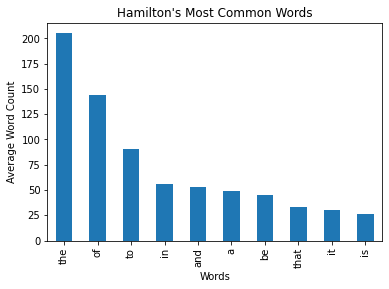

In [86]:
df_authorship = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
df_comb = df_authorship.join(tf)
df_comb = df_comb.drop(['Paper'], axis = 1)
df_comb = df_comb.groupby("Author").mean()
find_top("Hamilton")


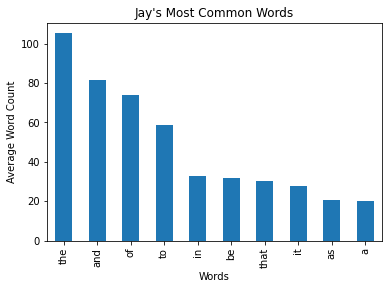

In [87]:
find_top("Jay")

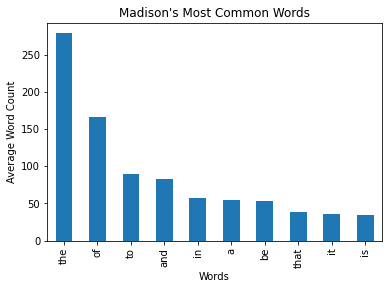

In [88]:
find_top("Madison")

## Question 3

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. (For example, if 3 of the 5 closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would predict that the disputed document was written by Hamilton.)

In [89]:
def findAuthor(names):
  jay = 0
  ham = 0
  mad = 0
  authors = ["Jay", "Hamilton", "Madison"]
  for name in names:
    if name == "Jay":
      jay += 1
    elif name == "Hamilton":
      ham += 1
    else:
      mad += 1
  count = [jay, ham, mad]
  return authors[count.index(max(count))]

In [90]:
#map unknown to known
from sklearn.metrics.pairwise import cosine_distances
unknown_indices = df_authorship[df_authorship['Author'].isnull()].index.tolist()
unknown_paper = []
single_paper = []
author = df_authorship['Author'].tolist()
for i in unknown_indices:
  dist = cosine_distances(tf)[i]
  indexOfPaper = ((dist).argsort())
  for val in indexOfPaper:
    if val not in unknown_indices and len(single_paper) < 5 :
        single_paper.append(author[val])
  unknown_paper.append(single_paper)
  single_paper = []

for i in range(len(unknown_paper)):
  print("Paper " + str(unknown_indices[i]) + "'s predicted author is " + findAuthor(unknown_paper[i]))


Paper 17's predicted author is Madison
Paper 18's predicted author is Madison
Paper 19's predicted author is Madison
Paper 48's predicted author is Hamilton
Paper 49's predicted author is Madison
Paper 50's predicted author is Madison
Paper 51's predicted author is Hamilton
Paper 52's predicted author is Madison
Paper 53's predicted author is Madison
Paper 54's predicted author is Hamilton
Paper 55's predicted author is Hamilton
Paper 56's predicted author is Madison
Paper 57's predicted author is Madison
Paper 61's predicted author is Madison
Paper 62's predicted author is Madison



Code explanation: I determined the 15 unknown papers and added them to a list. For all of the unknown papers I found the cosine distances between them and all the other papers. I found the indices of all the papers and sorted them from low to high distances and found the top 5 authors for each unknown paper.